📌 Extracting frames...
📌 Detecting shot boundaries...
🔍 Motion stats: min=2.54, max=10.62, mean=6.82
✅ Shot Boundaries Detected: [61, 62, 63, 74, 75, 76]
📌 Extracting histogram features...
📌 Building shot similarity graph...
📌 Visualizing shot similarity graph...


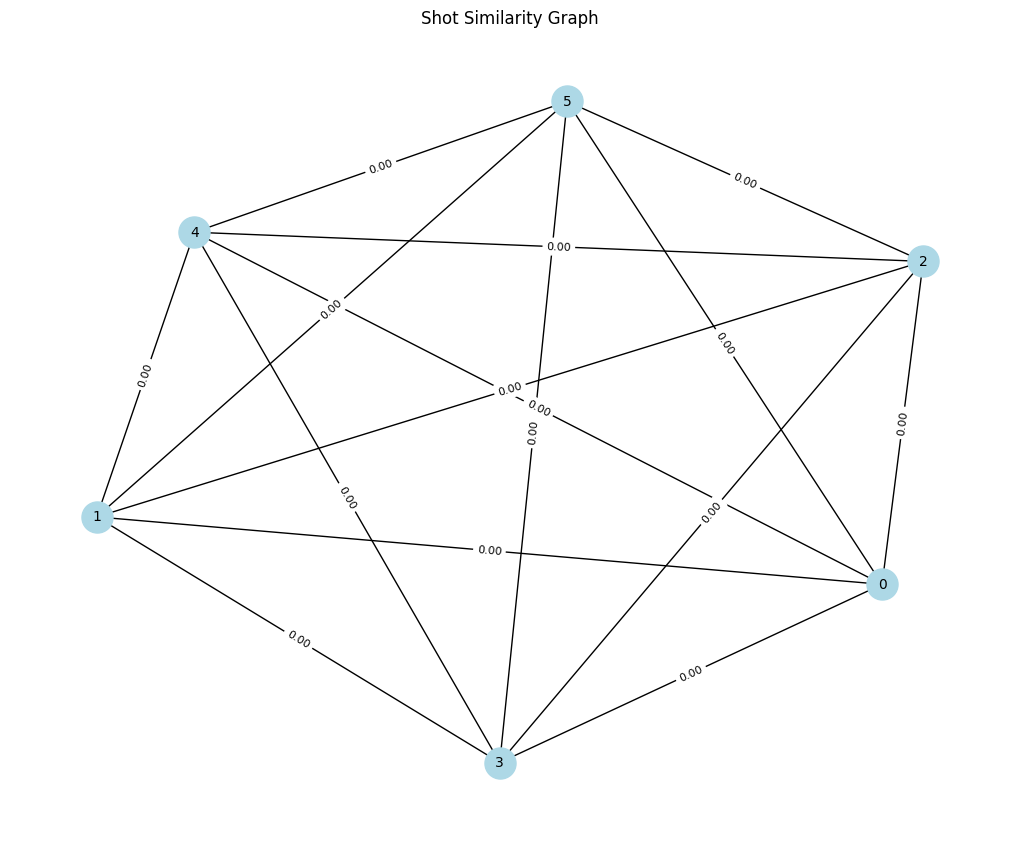

📌 Computing Must-Link & Cannot-Link constraints...
✅ Must-Link Constraints: 0
✅ Cannot-Link Constraints: 0
📌 Running Random Walk Label Propagation...
📌 Generating summarized video...
✅ Summary saved to /Users/rutu/Desktop/untitled folder 2/_xMr-HKMfVA.mp4


In [9]:
import cv2
import os
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.spatial.distance import cityblock
from scipy.stats import entropy
import requests

# ==========================
# 0️⃣ Download Recommended Video
# ==========================
def download_recommended_video(output_path="EE-bNr36nyA.mp4"):
    """
    Downloads a recommended video from Pexels (Travel Montage, ~1 min, MP4).
    Replace the URL with a direct Pexels video link if needed.
    """
    video_url = "https://videos.pexels.com/video-files/1526909/1526909-hd_1280_720_24fps.mp4"
    print(f"📌 Downloading recommended video from {video_url}...")
    
    try:
        response = requests.get(video_url, stream=True)
        if response.status_code == 200:
            with open(output_path, 'wb') as f:
                for chunk in response.iter_content(chunk_size=1024):
                    if chunk:
                        f.write(chunk)
            print(f"✅ Video downloaded to {output_path}")
        else:
            raise Exception(f"Failed to download video (status code: {response.status_code})")
    except Exception as e:
        print(f"❌ Error downloading video: {str(e)}")
        print("Please download a video manually from https://www.pexels.com/videos/ (e.g., search 'travel montage')")
        return False
    return True

# ==========================
# 1️⃣ Extract Frames from Video
# ==========================
def extract_frames(video_path, frames_dir):
    if not os.path.exists(video_path):
        raise FileNotFoundError(f"Video file {video_path} not found")
    
    os.makedirs(frames_dir, exist_ok=True)

    cap = cv2.VideoCapture(video_path)
    frame_count = 0
    frame_paths = []

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        frame_filename = f"{frames_dir}/frame_{frame_count:04d}.jpg"
        cv2.imwrite(frame_filename, frame)
        frame_paths.append(frame_filename)

        frame_count += 1

    cap.release()
    return frame_paths

# ==========================
# 2️⃣ Detect Shot Boundaries
# ==========================
def detect_shot_boundaries(frame_paths, threshold=10):
    shot_boundaries = []
    prev_frame = None
    motion_values = []

    for i, frame_path in enumerate(frame_paths):
        frame = cv2.imread(frame_path, cv2.IMREAD_GRAYSCALE)

        if prev_frame is not None:
            diff = cv2.absdiff(frame, prev_frame)
            motion = np.mean(diff)
            motion_values.append(motion)

            if motion > threshold:
                shot_boundaries.append(i)

        prev_frame = frame

    if motion_values:
        print(f"🔍 Motion stats: min={min(motion_values):.2f}, max={max(motion_values):.2f}, mean={np.mean(motion_values):.2f}")
    
    if not shot_boundaries and frame_paths:
        print("⚠️ No shot boundaries detected. Using first frame as fallback.")
        shot_boundaries.append(0)

    return shot_boundaries

# ==========================
# 3️⃣ Extract Histogram Features
# ==========================
def extract_histogram_features(frame_path):
    img = cv2.imread(frame_path)
    hist = cv2.calcHist([img], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
    hist = cv2.normalize(hist, hist).flatten()
    return hist

# ==========================
# 4️⃣ Build Graph Representation
# ==========================
def kl_divergence(p, q):
    return entropy(p + 1e-10, q + 1e-10)

def build_graph(features):
    G = nx.Graph()
    num_shots = len(features)

    for i in range(num_shots):
        for j in range(i + 1, num_shots):
            city_dist = cityblock(features[i], features[j])
            kl_div = kl_divergence(features[i], features[j])
            weight = city_dist * kl_div
            G.add_edge(i, j, weight=weight)

    return G

# ==========================
# 5️⃣ Visualize Graph
# ==========================
def visualize_graph(graph):
    """
    Visualizes the shot similarity graph with edge weights.
    """
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(graph)  # Layout for node positions
    nx.draw(graph, pos, with_labels=True, node_color='lightblue', node_size=500, font_size=10)
    
    # Draw edge labels (weights)
    edge_labels = nx.get_edge_attributes(graph, 'weight')
    edge_labels = {k: f"{v:.2f}" for k, v in edge_labels.items()}  # Round weights for readability
    nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels, font_size=8)
    
    plt.title("Shot Similarity Graph")
    plt.show()

# ==========================
# 6️⃣ Compute Must-Link & Cannot-Link Constraints
# ==========================
def compute_constraints(graph):
    edges = list(graph.edges(data=True))
    weights = np.array([w['weight'] for _, _, w in edges])

    mean_w, std_w = np.mean(weights), np.std(weights)
    ml_threshold = mean_w - 1.5 * std_w
    cl_threshold = mean_w + 3.0 * std_w

    ML, CL = [], []
    for u, v, w in edges:
        if w['weight'] <= ml_threshold:
            ML.append((u, v))
        elif w['weight'] >= cl_threshold:
            CL.append((u, v))

    return ML, CL

# ==========================
# 7️⃣ Random Walk for Label Propagation
# ==========================
from scipy.sparse.linalg import cg

def compute_laplacian(graph):
    A = nx.to_scipy_sparse_array(graph, format="csr")
    D = np.diag(A.sum(axis=1).flatten())
    L = D - A
    return L

def label_propagation(graph, seed_labels):
    L = compute_laplacian(graph)
    b = np.zeros(len(graph.nodes))

    for node, label in seed_labels.items():
        b[node] = label

    x, _ = cg(L, -b)
    labels = {i: int(round(x[i])) for i in range(len(graph.nodes))}
    return labels

# ==========================
# 8️⃣ Generate Summarized Video
# ==========================
def generate_summary(frame_paths, shot_boundaries, labels, output_path="/Users/rutu/Desktop/untitled folder 2/_xMr-HKMfVA.mp4"):
    selected_frames = []
    cluster_representatives = {}

    os.makedirs(os.path.dirname(output_path), exist_ok=True)

    for shot_idx, cluster in labels.items():
        if cluster not in cluster_representatives:
            frame_idx = shot_boundaries[shot_idx]
            cluster_representatives[cluster] = frame_paths[frame_idx]

    selected_frames = [cv2.imread(frame_path) for frame_path in cluster_representatives.values()]

    if not selected_frames:
        raise ValueError("No frames selected for summary")

    height, width, layers = selected_frames[0].shape
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    video = cv2.VideoWriter(output_path, fourcc, 1, (width, height))

    for frame in selected_frames:
        video.write(frame)

    video.release()
    print(f"✅ Summary saved to {output_path}")

# ==========================
# 🔥 Running the Full Pipeline
# ==========================
def main():
    video_path = "EE-bNr36nyA.mp4"
    frames_dir = "extracted_frames"

    try:
        if not os.path.exists(video_path):
            print(f"❌ Video file {video_path} not found. Attempting to download recommended video...")
            if not download_recommended_video(video_path):
                raise FileNotFoundError("Failed to download video. Please provide a valid video file.")

        print("📌 Extracting frames...")
        frame_paths = extract_frames(video_path, frames_dir)

        print("📌 Detecting shot boundaries...")
        shot_boundaries = detect_shot_boundaries(frame_paths)

        print(f"✅ Shot Boundaries Detected: {shot_boundaries}")

        print("📌 Extracting histogram features...")
        features = np.array([extract_histogram_features(frame_paths[i]) for i in shot_boundaries])

        print("📌 Building shot similarity graph...")
        graph = build_graph(features)

        print("📌 Visualizing shot similarity graph...")
        visualize_graph(graph)

        print("📌 Computing Must-Link & Cannot-Link constraints...")
        ML, CL = compute_constraints(graph)

        print(f"✅ Must-Link Constraints: {len(ML)}")
        print(f"✅ Cannot-Link Constraints: {len(CL)}")

        print("📌 Running Random Walk Label Propagation...")
        seed_labels = {i: i % 5 for i in range(min(5, len(shot_boundaries)))}
        labels = label_propagation(graph=graph, seed_labels=seed_labels)

        print("📌 Generating summarized video...")
        generate_summary(frame_paths, shot_boundaries, labels)

    except Exception as e:
        print(f"❌ Error: {str(e)}")

if __name__ == "__main__":
    main()